#### Steps to setup Openbb SDK in Jupyter notebook

1. Check conda version

    $ conda --version 

2. Update conda recommended

    $ conda update -n base -c conda-forge conda

3. Setup and activate the `meta-labell` environment

    $ conda env create --file=environment.yaml

    $ conda activate meta-labell    

4. Install openbb sdk
    
    $ pip install "openbb" --no-cache-dir              

### Introduction 
This notebook studies fundamentals and price signals of common cryptocurrencies using the OpenBB SDK. We consider the universe of cryptos with at least a $ 100 Million USD market capitalization on Coinmarketcap.   

In [2]:
%load_ext lineapy

The lineapy extension is already loaded. To reload it, use:
  %reload_ext lineapy


In [1]:
from openbb_terminal.sdk import openbb
# Show trending coins
openbb.crypto.disc.trending()

Forecasting Toolkit is disabled. To use the Forecasting features please install the toolkit following the instructions here: https://my.openbb.co/app/sdk/installation

Portfolio Optimization Toolkit is disabled. To use the Optimization features please install the toolkit following the instructions here: https://my.openbb.co/app/sdk/installation

,Symbol,Name,market_cap Cap Rank
0,bella-protocol,Bella Protocol,470
1,bonk,Bonk,933
2,gala,GALA,93
3,trust-wallet-token,Trust Wallet,100
4,bitcoin,Bitcoin,1
5,qanplatform,QANplatform,290
6,veloce-vext,Veloce,809


In [2]:
import pandas as pd
from openbb_terminal.sdk import openbb
%matplotlib inline

In [3]:
trades_ethusdt = openbb.crypto.dd.trades(exchange_id = 'coinbaseprime', symbol = 'ETH', to_symbol = 'USDT')

trades_ethusdt.tail(5)

,Date,Price,Amount,Cost,Side
995,2023-09-13 02:33:26.842000+00:00,1596.18,0.059180,94.461932,buy
996,2023-09-13 02:33:26.842000+00:00,1596.30,0.020820,33.234966,buy
997,2023-09-13 02:33:27.203000+00:00,1596.21,0.003672,5.861523,sell
998,2023-09-13 02:36:56.458000+00:00,1596.37,0.371837,593.588937,buy
999,2023-09-13 02:36:56.458000+00:00,1596.39,0.618700,987.686493,buy


In [4]:
btc_df = openbb.crypto.load(symbol="btc",to_symbol="usd",start_date="2019-01-01",source="YahooFinance")
btc_df.tail(5)

,Open,High,Low,Close,Adj Close,Volume
date,,,,,,
2023-09-07,25748.312500,26409.302734,25608.201172,26240.195312,26240.195312,11088307100
2023-09-08,26245.208984,26414.005859,25677.480469,25905.654297,25905.654297,10817356400
2023-09-09,25905.425781,25921.976562,25810.494141,25895.677734,25895.677734,5481314132
2023-09-10,25895.210938,25978.130859,25640.261719,25832.226562,25832.226562,7899553047
2023-09-11,25831.714844,25883.947266,24930.296875,25162.654297,25162.654297,14600006467


Text(0.0, 1.0, 'BTC Price Over Time')

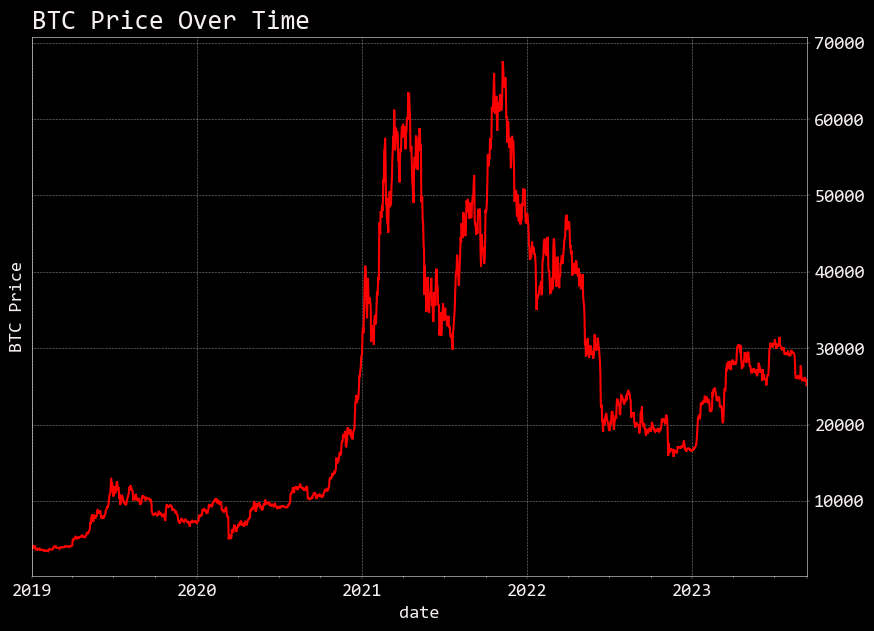

In [5]:
# Plot the Adj Close price overtime for BTC
import matplotlib.pyplot as plt

btc_df['Adj Close'].plot(figsize=(10, 7), color='r')
plt.ylabel('BTC Price')
plt.title('BTC Price Over Time')